In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(str('/home/alexandre/Documents/Projects'))

from slmOptim.patternSLM import patterns as pt
from slmOptim.optimization.init_experiment import InitExperiment
from slmOptim.optimization.iteration_algorithms import IterationAlgos

from slmOptim.optimization import cost_functions

from aotools.functions import phaseFromZernikes


In [2]:
# Define observation window on camera
roi_size = 100
off = (-25, 10 )

# Define camera macropixel, this is defined by the measured speckel grain
bins = 1

# Define camera acquisition parameters
exposure_time = 10
gain = 1
timeout= 100


Connected to 10.42.0.234 on 9999
(104, 100)


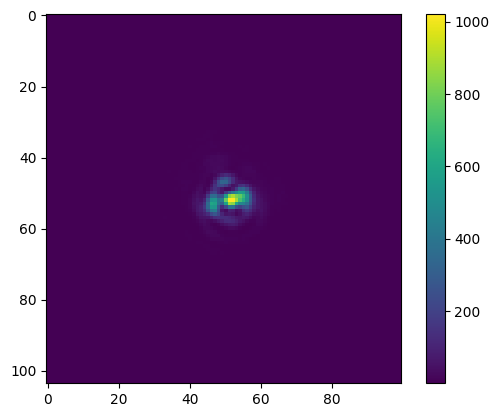

In [3]:
init = InitExperiment(roi_size, off, bins, exposure_time, gain, timeout)
camera = init.init_cam()
slm = init.init_slm()

frame = camera.get_pending_frame_or_null()
frame = np.copy(frame.image_buffer)
plt.imshow(frame)
plt.colorbar()
init.close_cam()

print(frame.shape)

In [6]:
frame = camera.get_pending_frame_or_null()
frame = np.copy(frame.image_buffer)

Unable to get pending frame; tl_camera_get_pending_frame_or_null() returned non-zero error code: 1004; error message: Camera handle is invalid. Error: Invalid operation.


TLCameraError: tl_camera_get_pending_frame_or_null() returned non-zero error code: 1004; error message: Camera handle is invalid. Error: Invalid operation.

In [ ]:
slm = init.init_slm()


In [4]:
class ZernikesPolynomials(IterationAlgos):
    
    def __init__(self, 
                slm, 
                camera,
                slm_resolution=(800, 600),
                slm_calibration_pixel=112,
                num_of_zernike_coeffs=8,
                radius=200, 
                center = [600 // 2, 800 // 2],
                remote=True,
                save_path=None):
        
        self.slm = slm
        self.camera = camera
        
        # SLM
        resX, resY = slm_resolution
        self.patternSLM = pt.Pattern(resX, resY)
        self.calib_px = slm_calibration_pixel
        self.shape = slm_resolution
        # Zernike
        self.num_of_zernike_coeffs = num_of_zernike_coeffs
        self.radius = radius
        self.center = center
        
        # is the slm remotely connected to a rasp pi ?
        self.remote = remote
        
        # save raw data path
        # self.save_path = save_path
        # self.filepath = self._create_filepath()
    
    
    
    def _get_disk_mask(self, center = None):
        '''
        Generate a binary mask with value 1 inside a disk, 0 elsewhere
        :param shape: list of integer, shape of the returned array
        :radius: integer, radius of the disk
        :center: list of integers, position of the center
        :return: numpy array, the resulting binary mask
        '''
        shape = [2 * self.radius] * 2
        if not center:
            center = (shape[0] // 2, shape[1] // 2)
        X, Y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]))
        mask = (Y - center[0]) ** 2 + (X - center[1]) ** 2 < self.radius ** 2
        return mask.astype('int8')
    
    def _complex_mask_from_zernike_coeff(self, vec):
        '''
        Generate a complex phase mask from a vector containting the coefficient of the first Zernike polynoms.
        :param DMD_resolution: list of integers, contains the resolution of the DMD, e.g. [1920,1200]
        :param: integer, radius of the illumination disk on the DMD
        :center: list of integers, contains the position of the center of the illumination disk
        :center: list of float, the coefficient of the first Zernike polynoms
        '''
        # Generate a complex phase mask from the coefficients
        zern_mask = np.exp(1j * phaseFromZernikes(vec, 2 * self.radius))
        
        # We want the amplitude to be 0 outside the disk, we fist generate a binary disk mask
        amp_mask = self._get_disk_mask()
        
        # put the Zernik mask at the right position and multiply by the disk mask
        mask = np.zeros(shape = self.shape, dtype='complex')
        mask[self.center[0] - self.radius:self.center[0] + self.radius,
            self.center[1] - self.radius:self.center[1] + self.radius] = zern_mask * amp_mask
        
        return abs(mask).astype('uint8')
    
    def run(self):
        
        counter = 0
        frames = {}
        cost = []
        
        coeffs = np.zeros(self.num_of_zernike_coeffs)
        phi_k = np.arange(-2, 2, 0.5)
        
        for idx in range(self.num_of_zernike_coeffs):
            cost_temp = []
            for phi in phi_k:
                coeffs[idx] = phi
                zmask = self._complex_mask_from_zernike_coeff(coeffs)
                self.upload_pattern(zmask, 0.1)
                
                    # get interferogram from camera
                frame = self.get_frame()

                # calculate correlation here
                cost_k = self.callback(frame)
                cost_temp.append(cost_k)
                
            counter += 1 
            frames[counter] = frame

            # update pattern with max corr
            self.cost.append(np.max(cost_temp))
            coeffs[idx] = phi

        return zmask, coeffs, cost
                

In [5]:
zern = ZernikesPolynomials(slm, camera)
cost_fun = lambda x: cost_functions.snr(x)
zern.register_callback(cost_fun)
mask = zern.run()



Unable to get pending frame; tl_camera_get_pending_frame_or_null() returned non-zero error code: 1004; error message: Camera handle is invalid. Error: Invalid operation.


Data transmitted


TLCameraError: tl_camera_get_pending_frame_or_null() returned non-zero error code: 1004; error message: Camera handle is invalid. Error: Invalid operation.

In [ ]:
init.close_cam()

In [ ]:
init.init_cam()

In [ ]:
zern.run()

In [ ]:
phi_k = np.arange(-2, 2.5, 0.25)
phi_k

In [ ]:
frames = {}
counter = 0

In [ ]:
counter += 1
counter 

In [ ]:
counter += 1
frame = camera.get_pending_frame_or_null()
frames[counter] = np.copy(frame.image_buffer)
plt.imshow(frames[counter])
plt.axis('off')
plt.savefig("frame" + str(counter) + ".png", bbox_inches='tight', pad_inches=0)

In [ ]:
frame = camera.get_pending_frame_or_null()
frame = np.copy(frame.image_buffer)
plt.imshow(frame)

In [ ]:
for i in range(12):
    plt.figure()
    plt.imshow(frames[i])

In [ ]:
with open("myfile2.txt", 'w') as f:  
    for key, value in frames.items():  
        f.write('%s\n' % (value))

In [ ]:
import pandas as pd
df = pd.read_csv("myfile2.txt", header=None)
print(df)

In [ ]:
df[0][0]

In [ ]:
df

In [ ]:
img = df[0][0]
img.shape

In [ ]:
radius = 200
[radius * 2] * 2